1. Import Libraries

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import numpy as np


2. Settings 

set hyperparameters, class have 3:normal, benign, malignant,pruning 30% of the model weights.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

num_classes = 3
batch_size = 16
epochs = 5
prune_amount = 0.3
data_dir = "data"  # should contain 'train' and 'val'


Using device: cuda
Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


3. Data Loaders :
resized to 224×224 and loads your data into batches ready for training

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize the image to 256x256
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.RandomRotation(10), # Randomly rotate the image by 10 degrees
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(f"{data_dir}/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


4. Model Selection Function : chosen model (ResNet50, DenseNet121, or EfficientNetB0) with the output layer modified for 3 classes.

In [4]:
# === Models ===
def get_model(model_name):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(device)


 5. Pruning Function : Prunes (zeroes out) 30% of the smallest weights in each convolutional and linear layer. This makes models lighter and faster, but may reduce accuracy.



In [5]:
# === Pruning Function ===
def apply_pruning(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    return model

 6. Training and Evaluation

In [6]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

#  evaluates accuracy each epoch. output Training loss,Validation accuracy
def train_model(model, name, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        val_acc = evaluate(model, val_loader)
        train_losses.append(avg_loss)
        val_accuracies.append(val_acc)

        print(f"{name} | Epoch {epoch+1}/{epochs}: Loss={avg_loss:.4f}, Val Acc={val_acc:.4f}")

    return {'name': name, 'loss': train_losses, 'val_acc': val_accuracies}


7. Train and Compare Models

In [7]:
models_to_run = ["resnet50", "densenet121", "efficientnet_b0"]
results = []

criterion = nn.CrossEntropyLoss()

for model_name in models_to_run:
    print(f"\nTraining {model_name.upper()}...")
    model = get_model(model_name)
    model = apply_pruning(model, amount=prune_amount)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    result = train_model(model, model_name, train_loader, val_loader, criterion, optimizer, epochs)
    results.append(result)



Training RESNET50...


d:\LernNewCode\Trymodel\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\LernNewCode\Trymodel\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet50 | Epoch 1/5: Loss=1.1357, Val Acc=0.1600
resnet50 | Epoch 2/5: Loss=0.9525, Val Acc=0.2400
resnet50 | Epoch 3/5: Loss=0.8132, Val Acc=0.3600
resnet50 | Epoch 4/5: Loss=0.7655, Val Acc=0.4800
resnet50 | Epoch 5/5: Loss=0.5616, Val Acc=0.6400

Training DENSENET121...


d:\LernNewCode\Trymodel\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


densenet121 | Epoch 1/5: Loss=1.1766, Val Acc=0.2000
densenet121 | Epoch 2/5: Loss=0.9941, Val Acc=0.2400
densenet121 | Epoch 3/5: Loss=0.8669, Val Acc=0.2800
densenet121 | Epoch 4/5: Loss=0.7676, Val Acc=0.2400
densenet121 | Epoch 5/5: Loss=0.7241, Val Acc=0.4000

Training EFFICIENTNET_B0...


d:\LernNewCode\Trymodel\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


efficientnet_b0 | Epoch 1/5: Loss=1.1298, Val Acc=0.6000
efficientnet_b0 | Epoch 2/5: Loss=1.0974, Val Acc=0.3600
efficientnet_b0 | Epoch 3/5: Loss=1.0832, Val Acc=0.4000
efficientnet_b0 | Epoch 4/5: Loss=1.0129, Val Acc=0.4000
efficientnet_b0 | Epoch 5/5: Loss=0.9683, Val Acc=0.4000


 8. Visualization of Model Comparison

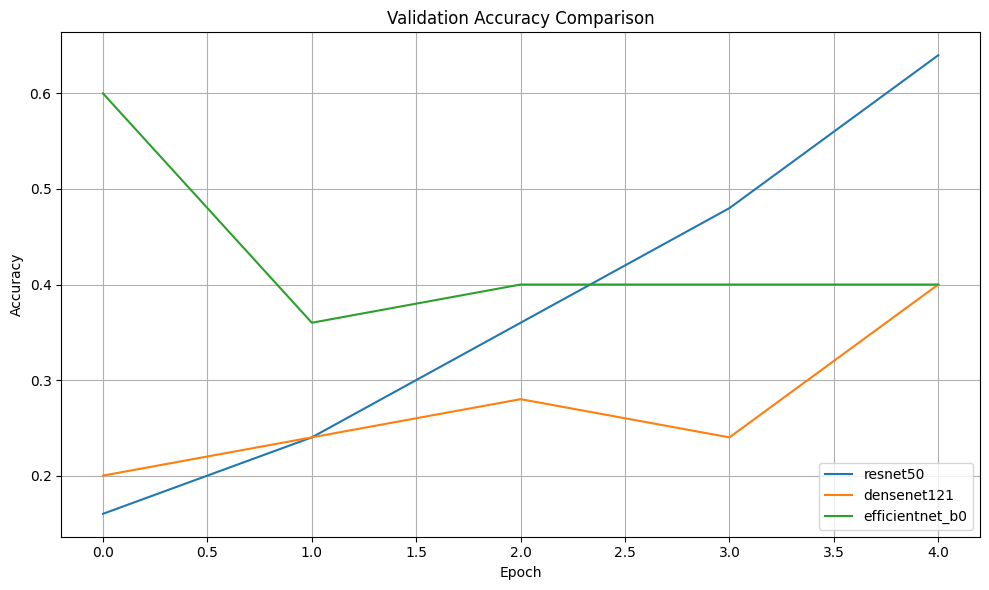

In [8]:
# Plotting validation accuracy for all models
plt.figure(figsize=(10, 6))

for res in results:
    plt.plot(res['val_acc'], label=res['name'])

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models to compare
models_to_test = {
    "ResNet50": models.resnet50(pretrained=True),
    "DenseNet121": models.densenet121(pretrained=True),
    "Efficientnet_B0": models.efficientnet_b0(pretrained=True),
}

results = []

for name, model in models_to_test.items():
    # Modify final layer
    if name == "ResNet50":
        model.fc = nn.Linear(model.fc.in_features, 3)
    elif name == "DenseNet121":
        model.classifier = nn.Linear(model.classifier.in_features, 3)
    elif name == "Efficientnet_B0":
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)

    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    result = train_model(model, name, train_loader, val_loader, criterion, optimizer, epochs=5)
    results.append(result)


ResNet50 | Epoch 1/5: Loss=1.1532, Val Acc=0.3200
ResNet50 | Epoch 2/5: Loss=0.9143, Val Acc=0.6000
ResNet50 | Epoch 3/5: Loss=0.7013, Val Acc=0.6000
ResNet50 | Epoch 4/5: Loss=0.5539, Val Acc=0.6000
ResNet50 | Epoch 5/5: Loss=0.4333, Val Acc=0.6000
DenseNet121 | Epoch 1/5: Loss=1.1171, Val Acc=0.4000
DenseNet121 | Epoch 2/5: Loss=0.9177, Val Acc=0.3600
DenseNet121 | Epoch 3/5: Loss=0.9003, Val Acc=0.3600
DenseNet121 | Epoch 4/5: Loss=0.7120, Val Acc=0.4400
DenseNet121 | Epoch 5/5: Loss=0.6444, Val Acc=0.4000
Efficientnet_B0 | Epoch 1/5: Loss=1.1048, Val Acc=0.5600
Efficientnet_B0 | Epoch 2/5: Loss=0.9898, Val Acc=0.4800
Efficientnet_B0 | Epoch 3/5: Loss=0.9530, Val Acc=0.5200
Efficientnet_B0 | Epoch 4/5: Loss=0.9128, Val Acc=0.4400
Efficientnet_B0 | Epoch 5/5: Loss=0.8627, Val Acc=0.4400


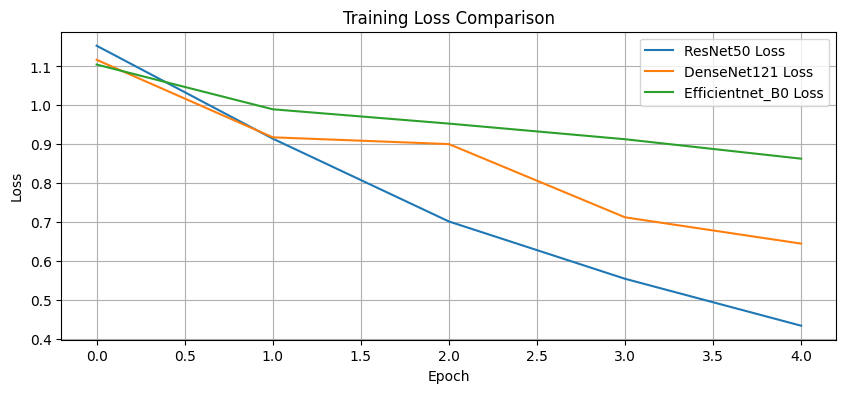

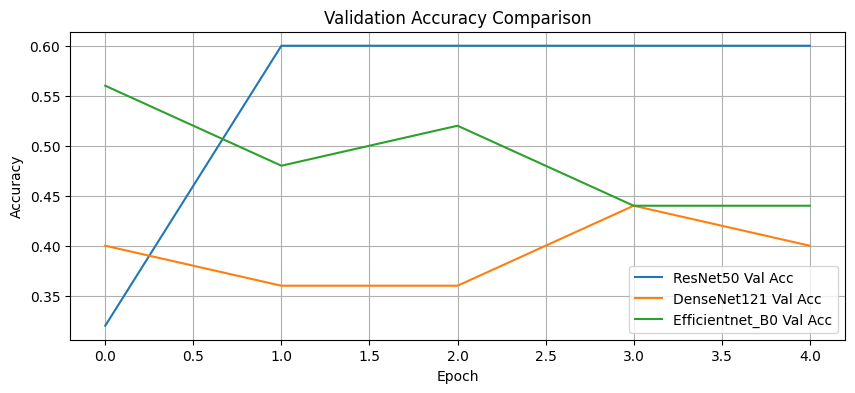

In [10]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
for res in results:
    plt.plot(res['loss'], label=f"{res['name']} Loss")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 4))
for res in results:
    plt.plot(res['val_acc'], label=f"{res['name']} Val Acc")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
